In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# EDA - evaluating training data

Time series data is tricky sometimes. The probability distribution may change with time (a non-stationary time series) and that messes everything up: you can't use the past to predict the future when it's non-stationary. Let's check that.

For the most of this notebook we'll use the sales by month set, so let's load it.

In [2]:
sales_train_by_month = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales-train-by-month.parquet'))

## Time-series behavior

Let's first look at the total sales by month, to give us an idea of trends.

<AxesSubplot:xlabel='date_block_num'>

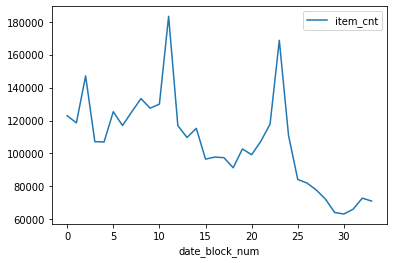

In [3]:
sales_train_by_month.groupby('date_block_num')['item_cnt'].sum().reset_index().plot.line(x='date_block_num', y='item_cnt')

Seems like they are in a downwards trend. There are some crazy peaks there, so let's check if they are related to the specific month.

In [4]:
sales_train_by_month['month_id'] = sales_train_by_month['date_block_num'] % 12
sales_train_by_month['year_id'] = sales_train_by_month['date_block_num'] // 12

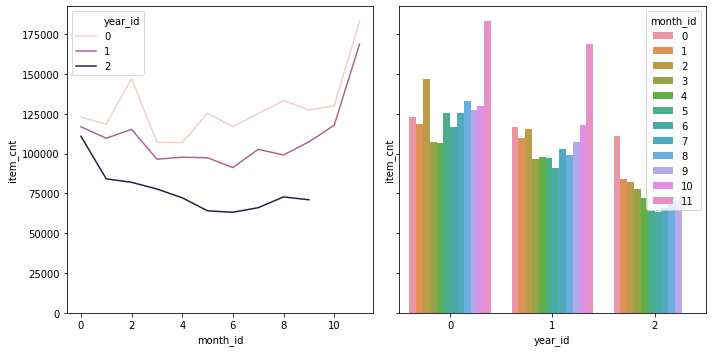

In [5]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
df_tmp = sales_train_by_month.groupby(['month_id', 'year_id'])['item_cnt'].sum().reset_index()
sns.lineplot(data=df_tmp, x='month_id', y='item_cnt', hue='year_id', ax=axes[0])
sns.barplot(data=df_tmp, x='year_id', y='item_cnt', hue='month_id', ax=axes[1])
plt.tight_layout()

Ok, month 11 really stands out from the rest on every year. It's interesting to see the relationship between monthly sales kind of match each year, specially if you see  the spikes around February, August and December. This _might_ mean it'd be ok for us to use all months for training.

In [6]:
date_block_nums = np.arange(0, sales_train_by_month['date_block_num'].max() + 2)
date_ids = pd.DataFrame({'date_block_num': date_block_nums,
                         'month_id': date_block_nums % 12,
                         'year_id': date_block_nums // 12})

## Item, shops, and categories over time

We analyzed the sales, but let's see how the number of items/categories/shops changed over the months. 

In [7]:
frequencies_df = sales_train_by_month.drop(columns=['item_cnt', 'month_id', 'year_id'])

In [8]:
frequencies_df

,date_block_num,shop_id,item_id
0,0,2,33
1,0,2,317
2,0,2,438
3,0,2,471
4,0,2,481
...,...,...,...
1600850,33,59,22087
1600851,33,59,22088
1600852,33,59,22091
1600853,33,59,22100


<AxesSubplot:xlabel='date_block_num'>

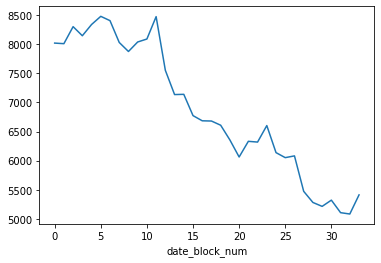

In [9]:
frequencies_df.groupby('date_block_num')['item_id'].nunique().plot.line()

<AxesSubplot:xlabel='date_block_num'>

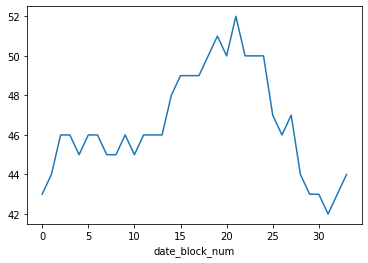

In [10]:
frequencies_df.groupby('date_block_num')['shop_id'].nunique().plot.line()

<AxesSubplot:xlabel='date_block_num'>

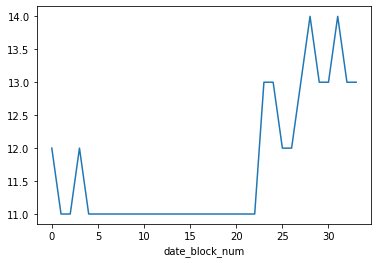

In [11]:
item_categories_metadata = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'item-categories-metadata.parquet'))
frequencies_df.merge(item_categories_metadata, on='item_id').groupby('date_block_num')['category_name'].nunique().plot.line()

We'll save all of this for feature engineering later. Not much else can do here probably.

In [12]:
sales_train_by_month\
    .merge(item_categories_metadata, on='item_id')\
    .groupby('date_block_num')\
    .agg({'category_name': 'nunique',
          'shop_id': 'nunique',
          'item_id': 'nunique'})\
    .reset_index()\
    .rename(columns={'category_name': 'nunique_category_names',
                     'shop_id': 'nunique_shop_ids',
                     'item_id': 'nunique_item_ids'})

,date_block_num,nunique_category_names,nunique_shop_ids,nunique_item_ids
0,0,12,43,8017
1,1,11,44,8007
2,2,11,46,8299
3,3,12,46,8143
4,4,11,45,8336
5,5,11,46,8476
6,6,11,46,8402
7,7,11,45,8028
8,8,11,45,7873
9,9,11,46,8036
